## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.training import Naive
#from avalanche.models import SimpleMLP, SimpleCNN
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST #,PermutedOmniglot, RotatedOmniglot

from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN, SimpleMLP

In [2]:
# Config
device = utils.get_device()

model = 'mlp'
n_classes = 10
n_epochs = 5
n_hidden_layers = 2
latent_layer_number = -1
freeze_below_layer = "end_features.0"
n_experiences = 3
input_size = 784
hidden_size = 32
penultimate_layer_dim = hidden_size
replay_buffer_size = n_experiences * 500

SEED = 492

sanity_check_ablation_naive = {'latent_layer_number':-1,
                         'freeze_below_layer': "end_features.0",
                         'replay_buffer_size': 0}
sanity_check_ablation_replay = {'latent_layer_number':-1,
                         'freeze_below_layer': "end_features.0",
                         'replay_buffer_size': 1500}
sanity_check_ablation_latent_replay = {'latent_layer_number':2,
                         'freeze_below_layer': "end_features.0",
                         'replay_buffer_size': 1500}

In [3]:
# Prepare for training & testing
l2 = 0.0005
momentum = 0.9
lr = 0.001

model_2 = SimpleMLP(
        input_size=input_size, 
        hidden_layers=n_hidden_layers,
        num_classes=n_classes, 
        hidden_size=hidden_size
        )

naive_strategy = Naive(
    model=model_2,
    criterion=CrossEntropyLoss(), 
    optimizer = SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32,
    device=device
    )

In [4]:
if model=='mlp':
    model = SimpleMLP(
        input_size=input_size, 
        hidden_layers=n_hidden_layers,
        num_classes=n_classes, 
        hidden_size=hidden_size
        )
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))])
    
elif model=='cnn':
    model = SimpleCNN(num_classes=n_classes)
    penultimate_layer_dim = 64
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose([
        #transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

In [5]:
# Prepare for training & testing

# Continual learning strategy
#cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device) 

cl_strategy = models.AR1(
    model=model, 
    penultimate_layer_dim=penultimate_layer_dim,
    criterion=CrossEntropyLoss(), 
    rm_sz=replay_buffer_size,
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32, 
    latent_layer_num=latent_layer_number, 
    freeze_below_layer=freeze_below_layer,
    device=device
    )

FrozenNet(
  (lat_features): Sequential(
    (0): Identity()
  )
  (end_features): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=32, out_features=10, bias=False)
)


c:\Users\jacob\Documents\GitHub\generative-latent-replay\models\ar1.py:114: UserWarning: The AR1 strategy implementation is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(


In [6]:
# train and test loop over the stream of experiences

for model, results in [
    (cl_strategy, (results_ar1 := [])),
    #(naive_strategy, (results_naive := []))
    ]:
    perm_mnist = RotatedMNIST(n_experiences=n_experiences, train_transform=transform, eval_transform=transform, seed=SEED)
    train_stream = perm_mnist.train_stream
    test_stream = perm_mnist.test_stream
    
    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(train_stream))

-- >> Start of training phase << --
100%|██████████| 1875/1875 [00:46<00:00, 40.62it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8398
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3491
100%|██████████| 1875/1875 [00:14<00:00, 132.15it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1740
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5791
100%|██████████| 1875/1875 [00:13<00:00, 134.00it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9719
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6664
100%|██████████| 1875/1875 [00:13<00:00, 134.12it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8636
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7116
100%|██████████| 1875/1875 [00:14<00:00, 132.89it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7949
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7416
-- >> End of training phase << --
-- >> Start of eval phase << --

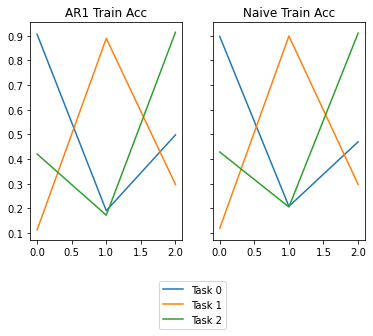

In [7]:
# JA: Next step - replace internal model.
# - model def ✅
# - frozen layer name ✅
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

fig, axes = plt.subplots(1, 2, sharey=True)

results_ar1_clean = utils.plot_results(results_ar1, 'AR1', axes[0], n_experiences, 'acc')
results_naive_clean = utils.plot_results(results_naive, 'Naive', axes[1], n_experiences, 'acc')
#results_ar1_clean = utils.plot_results(results_ar1, 'AR1', axes[1][0], 'loss')
#results_naive_clean = utils.plot_results(results_naive, 'Naive', axes[1][1], 'loss')

#print(results_ar1_clean["train"]['acc'])
#print(results_naive_clean["train"]['acc'])

utils.plot_single_legend(fig)